Копируем репозиторий с моделями.

In [ ]:
!git clone https://github.com/AntixK/PyTorch-VAE
import os
os.chdir("/content/PyTorch-VAE")
!pip install -r requirements.txt

Загружаем папки с фотографием.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Код для создания набора данных CelebA, в случае неработания функции библитечной.

In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as func

import torchvision as vision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.manifold import TSNE
# from torchvision import transform

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = './my_data'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 64
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Основная модель, в которой можно менять архитектуру и функцию потерь

In [ ]:
import os
import zipfile
os.chdir("/content/PyTorch-VAE")
from models.types_ import *
from scipy.spatial import distance_matrix

import torch
import torch.nn.functional as F
from models import BaseVAE
from torch import nn


class LogCoshVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 alpha: float = 100.,
                 beta: float = 10.,
                 gamma1: float = 0.,
                 gamma2: float = 0.,
                 teta1: float = 0.,
                 teta2: float = 0.,
                 **kwargs) -> None:
        super(LogCoshVAE, self).__init__()

        self.latent_dim = latent_dim
        self.alpha = alpha
        self.beta = beta
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.teta1 = teta1
        self.teta2 = teta2
        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        target = kwargs['target']
        t = recons - input
        # recons_loss = F.mse_loss(recons, input)
        # cosh = torch.cosh(self.alpha * t)
        # recons_loss = (1./self.alpha * torch.log(cosh)).mean()

        recons_loss = self.alpha * t + \
                      torch.log(1. + torch.exp(- 2 * self.alpha * t)) - \
                      torch.log(torch.tensor(2.0))
        # print(self.alpha* t.max(), self.alpha*t.min())
        recons_loss = (1. / self.alpha) * recons_loss.mean()

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        ones = torch.ones(48) #.to("cuda")                                                        !!!!! добавить cuda в случае обучения на видеокарте
        zeros = torch.zeros(80) #.to("cuda")                                                      !!!!! добавить cuda в случае обучения на видеокарте
        ones_zeros = torch.cat([ones,zeros])

        new_mu = F.normalize(mu * ones_zeros, p=2, dim=1)
        new_log_var = F.normalize(log_var * ones_zeros, p=2, dim=1)

        my_loss_mu = torch.cdist(new_mu, new_mu, 2)       
        my_loss_log_var = torch.cdist(new_log_var, new_log_var, 2)
        new_target = target.unsqueeze(1).type(torch.FloatTensor) # !!!!!!!!!! добавить cuda в случае обучения на видеокарте
        temp = torch.cdist(new_target, new_target, 1)
        not_sim = (temp != 0).type(torch.FloatTensor) # !!!!!!!!!! добавить cuda в случае обучения на видеокарте
        sim = (temp == 0).type(torch.FloatTensor) # !!!!!!!!! добавить cuda в случае обучения на видеокарте

        loss = recons_loss + self.beta * kld_weight * kld_loss + (self.gamma1 * torch.sum(my_loss_mu * sim) / 2) - (self.gamma2 * torch.sum(my_loss_mu * not_sim) / 2) + (self.teta1 * torch.sum(my_loss_log_var * sim) / 2) - (self.teta2 * torch.sum(my_loss_log_var * not_sim) / 2)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

        

Обёртка над моделью для генерации датасетов и других полезных вещей

In [ ]:
import os
import zipfile
os.chdir("/content/PyTorch-VAE")

import math
import torch
from torch import optim
from models import BaseVAE
from models.types_ import *
from utils import data_loader
import pytorch_lightning as pl
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset



import gdown

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
from copy import deepcopy

from pytorch_lightning.logging import TestTubeLogger

all_names = dict()
EPOCH = 0
id_num = 1

class my_Dataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)
    global id_num
    if (all_names.get(root_dir) == None):
        all_names[root_dir] = id_num
        id_num += 1  
    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)
    self.tag = all_names[root_dir]

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img, self.tag


class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model: BaseVAE,
                 logger: TestTubeLogger,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.logger = tt_logger
        self.curr_device = None
        self.hold_graph = False
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input, **kwargs)

    def training_step(self, batch, batch_idx, target, optimizer_idx = 0):
        real_img = batch
        self.curr_device = real_img.device
        results = self.forward(real_img)
        train_loss = self.model.loss_function(*results,
                                              M_N = self.params['batch_size']/ self.num_train_imgs,
                                              optimizer_idx=optimizer_idx,
                                              batch_idx=batch_idx,
                                              target=target)
        self.logger.experiment.log({key: val.item() for key, val in train_loss.items()})
        return train_loss

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img = batch
        self.curr_device = real_img.device

        results = self.forward(real_img)
        val_loss = self.model.loss_function(*results,
                                            M_N = self.params['batch_size']/ self.num_val_imgs,
                                            optimizer_idx = optimizer_idx,
                                            batch_idx = batch_idx)

        return val_loss

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'avg_val_loss': avg_loss}
        self.sample_images()
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def sample_images(self):
        # Get sample reconstruction image
        test_input = next(iter(self.sample_dataloader))[0]
        test_input = test_input.to(self.curr_device)
        recons = self.model.generate(test_input)
        vutils.save_image(torch.cat((test_input,recons.data)),
                          f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                          f"recons_{self.logger.name}_{EPOCH}.png",
                          normalize=True,
                          nrow=5)

        # vutils.save_image(test_input.data,
        #                   f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
        #                   f"real_img_{self.logger.name}_{self.current_epoch}.png",
        #                   normalize=True,
        #                   nrow=12)

        try:
            samples = self.model.sample(25,
                                        self.curr_device,
                                        labels = test_label)
            vutils.save_image(samples.cpu().data,
                              f"{self.logger.save_dir}{self.logger.name}/version_{self.logger.version}/"
                              f"{self.logger.name}_{EPOCH}.png",
                              normalize=True,
                              nrow=12)
        except:
            pass


        del test_input, recons #, samples


    def configure_optimizers(self):

        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.params['LR'],
                               weight_decay=self.params['weight_decay'])
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(getattr(self.model,self.params['submodel']).parameters(),
                                        lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(optims[0],
                                                             gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(optims[1],
                                                                      gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

    @data_loader
    def train_dataloader(self):
        transform = self.data_transforms()
        all_datasets = []
        for i in qwerty:
            all_datasets.append(my_Dataset("/content/gdrive/MyDrive/" + i, transform))
        
        dataset = ConcatDataset(all_datasets)

        self.num_train_imgs = len(dataset)
        return DataLoader(dataset,
                          batch_size= self.params['batch_size'],
                          shuffle = True,
                          drop_last=True)


    @data_loader
    def val_dataloader(self):
        transform = self.data_transforms()
        all_datasets = []
        for i in qwerty:
            all_datasets.append(my_Dataset("/content/gdrive/MyDrive/" + i, transform))
        
        dataset = ConcatDataset(all_datasets)
        self.sample_dataloader =  DataLoader(dataset,
                                            batch_size= 25,
                                            shuffle = True,
                                            drop_last=True)

        self.num_val_imgs = len(self.sample_dataloader)

        return self.sample_dataloader

    def data_transforms(self):

        SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
        SetScale = transforms.Lambda(lambda X: X/X.sum(0).expand_as(X))

        if self.params['dataset'] == 'celeba':
            transform = transforms.Compose([
                                            transforms.ToTensor()])
        else:
            raise ValueError('Undefined dataset type')
        return transform


Основной код для запуска

In [ ]:
model = LogCoshVAE(
  in_channels= 3,
  latent_dim= 128,
  alpha= 10.0,
  beta= 1.0,
  gamma1= 0.01, #близость из одного класса для матожидания
  teta1= 0.01, #близость из одного класса для дисперсии
  gamma2= 0.01, #дальность из разных классов
  teta2= 0.01)#.to("cuda")                                                                                 !!!

tt_logger = TestTubeLogger(
    save_dir="logs/",
    name="LogCoshVAE",
    debug=False,
    create_git_tag=False,
)

exp_params = {
  'dataset': 'celeba',
  'data_path': "../../shared/momo/Data/",
  'img_size': 64,
  'batch_size': 64, # Better to have a square number
  'LR': 0.005,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.97
}

checkpoint = torch.load("/content/gdrive/MyDrive/checkpoints/29model3.pt", map_location=torch.device('cpu')) #      !!!! Поменять "cpu" на "cuda" если обучаешь на видеокарте
model.load_state_dict(checkpoint['model_state_dict'])

exper = VAEXperiment(model,tt_logger, exp_params)#.to("cuda")


optimiz = exper.configure_optimizers() [0][0]
optimiz.load_state_dict(checkpoint['optimizer_state_dict'])
qwerty = ["new_alisa", "new_ilnur", "new_ilyas", "new_misha", "new_vanya"]  # место хранения фотографий разных людей
dataset = exper.train_dataloader()
val = exper.val_dataloader()
for i in range(20):
    loss = 0
    EPOCH = i
    for batch_idx, (data, target) in enumerate(dataset):
        optimiz.zero_grad()
        loss = exper.training_step(data, batch_idx, target) #                       !!!!! .to("cuda") если на видеокарте
        loss['loss'].backward()
        optimiz.step()
    # exper.sample_images()                    # в PyTorch-VAE/logs будут показывать примеры картинок
    torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimiz.state_dict(),
            'loss': loss,
            }, "/content/gdrive/MyDrive/checkpoints/" + str(i) + "model3.pt")


Протестировать модель на фотографии

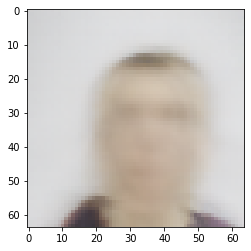

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import cv2
photo = "/content/gdrive/MyDrive/new_ilnur/ilnur240.jpg"
d = torch.from_numpy(np.array([cv2.imread(photo).transpose(2,0,1)]))
a = model.generate(d.type(torch.FloatTensor))#       !!!! добавить cuda если на видеокарте
b = a.to("cpu").detach().numpy()[0].transpose(1,2,0)
plt.imshow(b)

Провести анализ первых компонент:

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import cv2

photo1 = "/content/gdrive/MyDrive/new_alisa/alisa240.jpg"
photo2 = "/content/gdrive/MyDrive/new_alisa/alisa2405.jpg"
photo3 = "/content/gdrive/MyDrive/new_ilnur/ilnur2405.jpg"
d = torch.from_numpy(np.array([cv2.imread(photo1).transpose(2,0,1)]))
c = torch.from_numpy(np.array([cv2.imread(photo2).transpose(2,0,1)]))
e = torch.from_numpy(np.array([cv2.imread(photo3).transpose(2,0,1)]))
a, b = model.encode(d.type(torch.FloatTensor))
a2, b2 = model.encode(c.type(torch.FloatTensor))
a3, b3 = model.encode(e.type(torch.FloatTensor))
ch = []
for i in range(len(a[0])):
    print( "%.5f" % abs(a[0][i]- a2[0][i]),  "%.5f" % abs(a2[0][i] - a3[0][i]))
    ch.append(int(abs(a[0][i]- a2[0][i]) < abs(a2[0][i] - a3[0][i])))
print("Доля близких компонент среди первых = ", (np.array(ch[:48]) == 1).sum() / len(ch[:48]))
print("Доля близких компонент среди последних = ", (np.array(ch[49:]) == 1).sum() / len(ch[49:]))